In [1]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path("../../data/processed")
X_train = pd.read_parquet(data_dir / "X_train.parquet")
X_val = pd.read_parquet(data_dir / "X_val.parquet")
y_train = pd.read_parquet(data_dir / "y_train.parquet").squeeze()
y_val = pd.read_parquet(data_dir / "y_val.parquet").squeeze()
X_test = pd.read_parquet(data_dir / "X_test.parquet")
test_ids = pd.read_parquet(data_dir / "test_ids.parquet")['id']

In [3]:
model = CatBoostRegressor(
    iterations=2000,          # Сколько деревьев строить (можно больше)
    learning_rate=0.05,       # Шаг обучения
    depth=6,                  # Глубина дерева
    eval_metric='R2',         # Метрика для отслеживания
    random_seed=42,
    verbose=200,              # Выводить инфу каждые 200 шагов
    early_stopping_rounds=100 # Если 100 шагов нет улучшений - стоп
)

In [4]:
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=False
)

0:	learn: 0.0806030	test: 0.0806020	best: 0.0806020 (0)	total: 222ms	remaining: 7m 24s
200:	learn: 0.8668671	test: 0.8668739	best: 0.8668739 (200)	total: 7.17s	remaining: 1m 4s
400:	learn: 0.8677971	test: 0.8675863	best: 0.8675863 (400)	total: 14s	remaining: 55.8s
600:	learn: 0.8682951	test: 0.8678694	best: 0.8678694 (600)	total: 22.8s	remaining: 53.1s
800:	learn: 0.8686542	test: 0.8680053	best: 0.8680053 (800)	total: 32.2s	remaining: 48.2s
1000:	learn: 0.8689668	test: 0.8681102	best: 0.8681102 (1000)	total: 41.5s	remaining: 41.4s
1200:	learn: 0.8692437	test: 0.8681781	best: 0.8681781 (1200)	total: 49s	remaining: 32.6s
1400:	learn: 0.8694904	test: 0.8682212	best: 0.8682214 (1397)	total: 55.8s	remaining: 23.9s
1600:	learn: 0.8697245	test: 0.8682698	best: 0.8682698 (1600)	total: 1m 2s	remaining: 15.6s
1800:	learn: 0.8699563	test: 0.8682979	best: 0.8682980 (1799)	total: 1m 9s	remaining: 7.67s
1999:	learn: 0.8701692	test: 0.8683112	best: 0.8683114 (1995)	total: 1m 16s	remaining: 0us

bestT

In [5]:
y_pred = model.predict(X_val)

In [6]:
y_pred = np.clip(y_pred, 0, 1)

print(f"Validation R2: {r2_score(y_val, y_pred):.5f}")

Validation R2: 0.86831


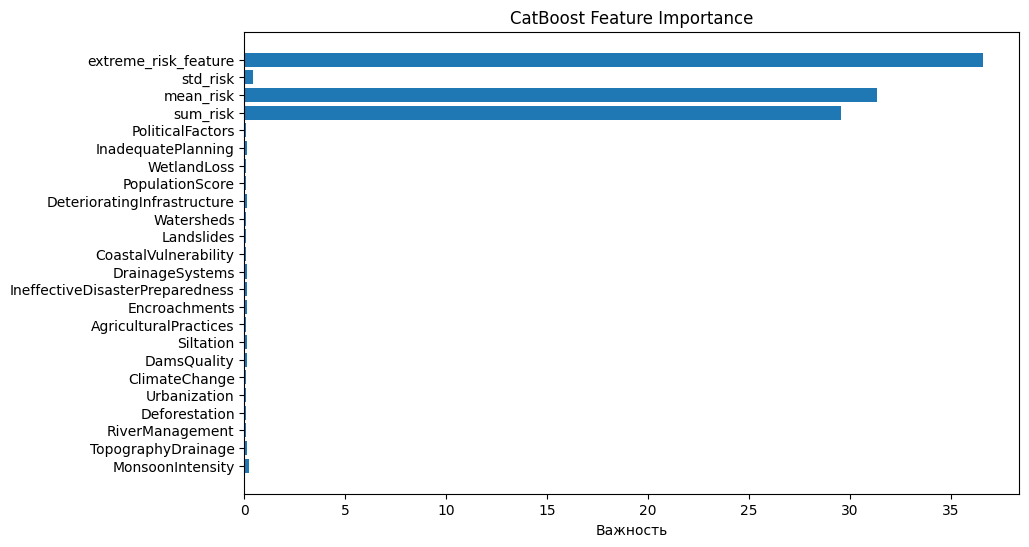

In [7]:
importance = model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance)
plt.title("CatBoost Feature Importance")
plt.xlabel("Важность")
plt.show()

In [8]:
test_pred = model.predict(X_test)
test_pred = np.clip(test_pred, 0, 1) # Обрезка

In [9]:
submission = pd.DataFrame({'id': test_ids, 'FloodProbability': test_pred})
submission.to_csv(data_dir / "submission_catboost.csv", index=False)
print("Saved submission_catboost.csv")

Saved submission_catboost.csv
